# Urban Intelligence Platform 

## Air Quality Analysis & CO Forecasting

## Objective 
The primary goal of this project is to analyze urban air quality, with a specific focus on Carbon Monoxide (CO) concentrations.
The workflow of the project includes:
- Data cleaning – handling missing and invalid sensor readings
- Exploratory Data Analysis (EDA) – understanding distributions, trends, and relationships
- Feature engineering – preparing variables suitable for modeling
- Time series forecasting – predicting short-term CO concentration levels
The objective is to identify temporal patterns in CO levels and evaluate the effectiveness of different machine learning models for short-term air quality prediction.

## Description Of The Datasets 
The dataset consists of hourly air quality measurements collected from urban monitoring sensors.
It includes the following variables:
1. Pollutant Concentrations
- Carbon Monoxide (CO)
- Nitrogen Oxides (NOx, NO₂)
- Non-Methane Hydrocarbons (NMHC)
- Benzene (C₆H₆)
  
2. Environmental Variables
- Temperature
- Relative Humidity
- Absolute Humidity
  
3. Sensor Readings
- Multiple PT08 metal oxide sensor measurements

4. Missing Data Handling
- Missing or invalid sensor readings are encoded using a sentinel value (-200).
- These values were systematically replaced with NaN (missing values) during preprocessing.

5. Time Indexing
- Date and time columns were combined into a single datetime index, enabling efficient time-series analysis and forecasting.

In [33]:
import pandas as pd                                 #handle the tabular/time series data
import numpy as np                                  #numerical operations.
import matplotlib.pyplot as plt                     #data visualization
import seaborn as sns                               #machine learning models
print ("the required envirionment is ready")

the required envirionment is ready


In [34]:
#loading the air quality dataset into ptyhon environment so that we can analyze the data.

air_quality = pd.read_csv("../data/raw/AirQualityUCI.csv",sep=",") #it reads  teh csv file and converts it into DataFrame(table with rows and columns.) 

air_quality.head() #displaying the data. shows first 5 rows of the dataframe.

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10-03-2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10-03-2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10-03-2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10-03-2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10-03-2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


## Data loding 
The data set was successfully loaded into the python environment. Initial inspection confirms the presence of the pollutant, sensors and time-related variables.

In [35]:
air_quality.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16'],
      dtype='object')

In [36]:
#clean columns names
air_quality.columns=(
    air_quality.columns
    .str.strip()                                    #removes leading and trailing space of column so taht we dont get errors later.
    .str.replace(" ", "_")                          #converting the space with underscores.
    .str.replace(".", "-")                          #replace "." with "-"
    .str.replace("(", "")                           #if there are "(" in teh comun name remove that.
    .str.replace(")", "")                           #if there are ")" in teh comun name remove that.
)

air_quality.columns

Index(['Date', 'Time', 'COGT', 'PT08-S1CO', 'NMHCGT', 'C6H6GT', 'PT08-S2NMHC',
       'NOxGT', 'PT08-S3NOx', 'NO2GT', 'PT08-S4NO2', 'PT08-S5O3', 'T', 'RH',
       'AH', 'Unnamed:_15', 'Unnamed:_16'],
      dtype='object')

## Column cleaning
To ensure consistency and avoid potential errors during data analysis and modeling, the column names were standardized.

In [37]:
air_quality=air_quality.loc[:, ~air_quality.columns.str.contains("Unnamed")]
air_quality.columns

Index(['Date', 'Time', 'COGT', 'PT08-S1CO', 'NMHCGT', 'C6H6GT', 'PT08-S2NMHC',
       'NOxGT', 'PT08-S3NOx', 'NO2GT', 'PT08-S4NO2', 'PT08-S5O3', 'T', 'RH',
       'AH'],
      dtype='object')

## Removing Unnamed Columns

Some CSV files contain extra columns labeled as `Unnamed`, which usually result from saved index columns or empty fields during file export.

In this step:
- We identify columns whose names contain the string `"Unnamed"`.
- We remove those columns while keeping all valid data columns.
- This helps clean the dataset and prevents unnecessary columns from interfering with analysis.

Finally, we display the remaining column names to confirm that the unwanted columns have been removed.


##  Creating a Datetime Column and Setting It as Index

The dataset contains separate `Date` and `Time` columns. In this step, we combine these two columns to create a single datetime column.

The following steps were performed:
- Concatenated the Date and Time columns into a single string
- Converted the combined string into a proper datetime object using pd.to_datetime()
- Explicitly specified the datetime format to ensure accurate parsing
- Used errors="coerce" to safely handle invalid or missing datetime values
- Set the newly created datetime column as the index of the DataFrame

This transformation is essential for:
- Time-series indexing
- Resampling and aggregation
- Trend analysis and forecasting
- Visualization of temporal patterns
After setting the datetime as the index, the dataset is properly structured for subsequent time-based analysis.


In [38]:
#create datetime in same column from two columns date and time
air_quality["datetime"]= pd.to_datetime(
    air_quality["Date"]+ " "+air_quality["Time"],
    format="%d-%m-%Y %H:%M:%S",
    errors="coerce"
)
#setting datetime as index
air_quality=air_quality.set_index("datetime")
air_quality.head()

,Date,Time,COGT,PT08-S1CO,NMHCGT,C6H6GT,PT08-S2NMHC,NOxGT,PT08-S3NOx,NO2GT,PT08-S4NO2,PT08-S5O3,T,RH,AH
datetime,,,,,,,,,,,,,,,
2004-03-10 18:00:00,10-03-2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,10-03-2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,10-03-2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,10-03-2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,10-03-2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


## Handling Missing Sensor Values
In the Air Quality dataset, the value -200 is used as a sentinel value to represent missing or invalid sensor measurements.

In this step:
- All occurrences of -200 are replaced with pandas’ missing value indicator (NaN)
- This prevents invalid sensor readings from influencing statistical calculations and visualizations
- The total number of missing values in each column is computed to assess data completeness
  
Proper handling of missing values is essential to ensure:
- Accurate exploratory data analysis
- Reliable feature engineering
- Robust machine learning and forecasting models
This step prepares the dataset for subsequent analysis by ensuring that missing data is handled consistently and correctly.


In [39]:
# Replace -200 (sensor missing value code) with NaN
air_quality = air_quality.replace(-200, pd.NA)

# Check missing values count
air_quality.isna().sum()


Date            114
Time            114
COGT           1797
PT08-S1CO       480
NMHCGT         8557
C6H6GT          480
PT08-S2NMHC     480
NOxGT          1753
PT08-S3NOx      480
NO2GT          1756
PT08-S4NO2      480
PT08-S5O3       480
T               480
RH              480
AH              480
dtype: int64

## Converting Columns to Numeric Data Types

Some sensor measurement columns are initially read as text (object type) due to missing values or formatting inconsistencies in the raw dataset.

In this step:
- All columns in the dataset are iterated over
- Every column except Date and Time is converted to a numeric data type using pd.to_numeric()
- Non-numeric or invalid values are safely converted to missing values using errors="coerce"
  
This conversion ensures that all sensor measurements are stored as numeric values, which is essential for:
- Statistical summaries
- Correlation analysis
- Data visualization
- Machine learning and time-series forecasting
  
Finally, the data types of all columns are displayed to confirm successful conversion.


In [40]:
# Convert all columns except Date and Time to numeric
for col in air_quality.columns:
    if col not in ["Date", "Time"]:
        air_quality[col] = pd.to_numeric(air_quality[col], errors="coerce")

# Verify data types
air_quality.dtypes


Date            object
Time            object
COGT           float64
PT08-S1CO      float64
NMHCGT         float64
C6H6GT         float64
PT08-S2NMHC    float64
NOxGT          float64
PT08-S3NOx     float64
NO2GT          float64
PT08-S4NO2     float64
PT08-S5O3      float64
T              float64
RH             float64
AH             float64
dtype: object

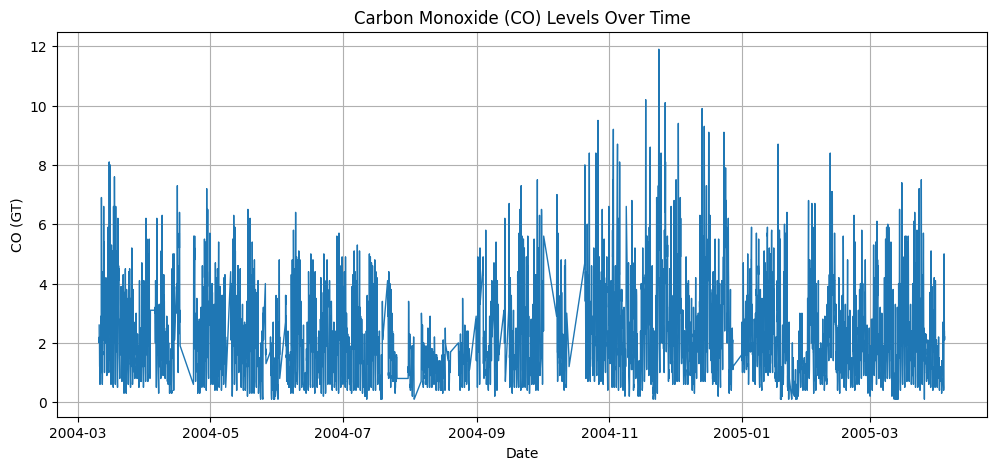

In [41]:
# Create clean CO series (fixes NA issue)
co_series = air_quality["COGT"].dropna()

# Plot correctly (index + values aligned)
plt.figure(figsize=(12, 5))
plt.plot(co_series.index, co_series, linewidth=1)

plt.title("Carbon Monoxide (CO) Levels Over Time")
plt.xlabel("Date")
plt.ylabel("CO (GT)")
plt.grid(True)

plt.show()


## Time-Series Plot of Carbon Monoxide (CO)

The time-series visualization of hourly Carbon Monoxide (CO) concentrations reveals substantial short-term variability, characterized by frequent spikes and rapid fluctuations. This behavior is typical of urban air-quality data, where pollutant levels are strongly influenced by dynamic factors such as traffic intensity, meteorological conditions, and localized emission sources.

Despite the high volatility, there is no clear evidence of a persistent long-term upward or downward trend over the observed period. Instead, CO concentrations oscillate within a relatively stable range, suggesting that while episodic pollution events occur, the overall pollution level remains structurally stable during the study window.

From a modeling perspective, this temporal pattern highlights the importance of time dependency in the data. It supports the use of time-series techniques such as lag features, rolling statistics, and temporal resampling to effectively capture both short-term fluctuations and broader temporal structure in CO concentrations.


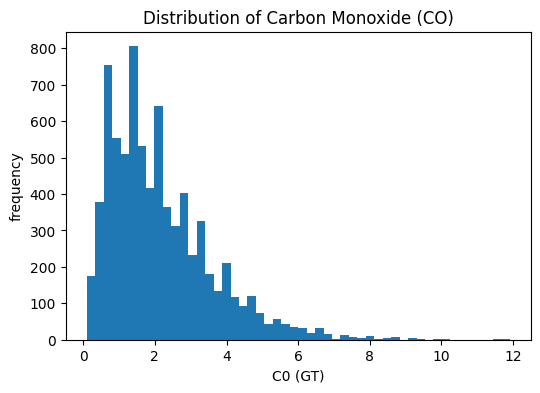

In [42]:
plt.figure(figsize=(6,4))
plt.hist(air_quality["COGT"].dropna(),bins=50)
plt.title("Distribution of Carbon Monoxide (CO)")
plt.xlabel("C0 (GT)")
plt.ylabel("frequency")
plt.show()

## Distribution of Carbon Monoxide (CO)
The histogram of Carbon Monoxide (CO) concentrations exhibits a right-skewed distribution, with the majority of observations clustered at lower concentration levels and a long tail extending toward higher values. This indicates that elevated CO events are relatively infrequent but can reach significantly higher magnitudes compared to typical background levels.
From a data perspective, most recorded CO values fall within a low-to-moderate range, reflecting normal urban air-quality conditions for the majority of the observation period. However, the presence of a long right tail highlights occasional extreme pollution episodes, which may be associated with factors such as traffic congestion, atmospheric stagnation, or adverse weather conditions.
Such skewed distributions are common in environmental sensor data, where routine conditions dominate most measurements and extreme values arise sporadically. The observed skewness suggests that mean-based statistics alone may not fully characterize the data, reinforcing the importance of robust measures (e.g., medians, quantiles) and non-linear or transformation-based modeling approaches in subsequent analysis.


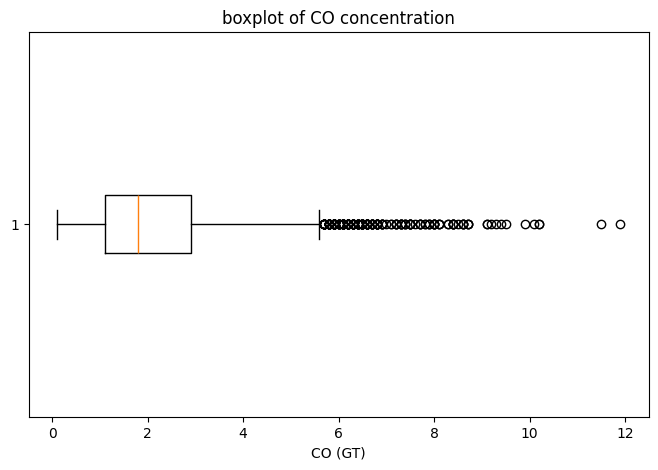

In [43]:
plt.figure(figsize=(8,5))
plt.boxplot(air_quality["COGT"].dropna(), vert=False)
plt.title("boxplot of CO concentration")
plt.xlabel("CO (GT)")
plt.show()

## Boxplot of Carbon Monoxide (CO)
The boxplot confirms substantial variability in Carbon Monoxide (CO) concentrations and highlights the presence of numerous high-value outliers. The median CO level lies closer to the lower quartile, further reinforcing the right-skewed nature of the distribution observed in the histogram.

From a data perspective, the compact interquartile range indicates that most CO measurements remain within a relatively narrow low-to-moderate concentration band. In contrast, the large number of points extending beyond the upper whisker reflects episodic extreme pollution events, during which CO concentrations rise sharply above typical background levels.

These outliers are unlikely to be data errors, given the prior removal of invalid sensor readings and systematic handling of missing values. Instead, they likely correspond to real-world phenomena such as heavy traffic periods, atmospheric stagnation, or adverse meteorological conditions.

From a modeling standpoint, this distribution suggests that forecasting models must be robust to heteroskedasticity and extreme values. Simple linear models may struggle to capture such behavior effectively, motivating the use of non-linear or tree-based approaches, as well as feature engineering techniques that explicitly account for temporal variability.

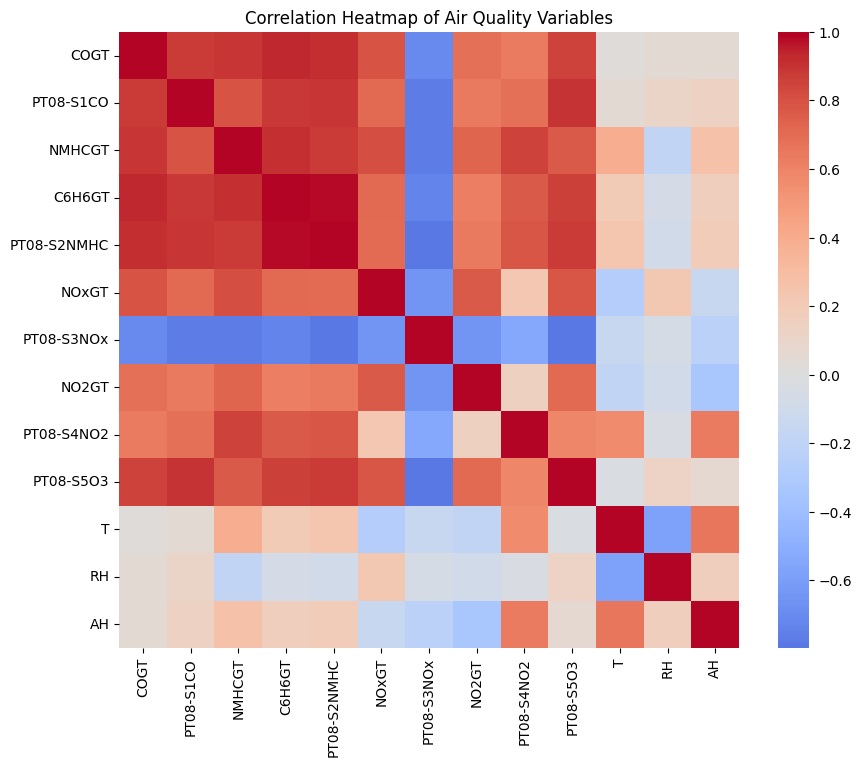

In [44]:


# Select numeric columns only
numeric_df = air_quality.select_dtypes(include="number")

plt.figure(figsize=(10, 8))
sns.heatmap(
    numeric_df.corr(),
    cmap="coolwarm",
    center=0
)

plt.title("Correlation Heatmap of Air Quality Variables")
plt.show()


## Correlation Heatmap of Air Quality Variables
The correlation heatmap illustrates the pairwise linear relationships among the numeric air-quality variables in the dataset. Strong positive correlations are observed among several gas-related measurements, particularly between Carbon Monoxide (CO), hydrocarbons, and nitrogen oxide compounds. These relationships reflect shared emission sources, such as vehicular traffic and combustion processes, as well as interconnected chemical dynamics commonly observed in urban environments.

In contrast, meteorological variables such as temperature and humidity exhibit weaker or negative correlations with certain pollutant measurements. This suggests more indirect and complex interactions, where atmospheric conditions influence pollutant dispersion and concentration rather than acting as direct emission sources.

From a modeling perspective, the presence of multicollinearity among sensor-based variables is an important observation. Highly correlated predictors can pose challenges for traditional linear models. This justifies the use of tree-based ensemble methods, such as Random Forests, which are robust to correlated features and well-suited for capturing non-linear relationships inherent in environmental sensor data.

To reduce short-term noise and highlight broader temporal trends, hourly Carbon Monoxide (CO) measurements were aggregated to a daily frequency using the mean value.
This aggregation serves multiple purposes:
Smooths high-frequency fluctuations observed in hourly data
Highlights medium- to long-term trends in CO concentration
Produces a more stable time series suitable for trend analysis and forecasting
Reduces computational complexity for downstream modeling
Daily aggregation is particularly useful in air-quality studies, where policy-relevant patterns often emerge at daily or longer time scales rather than at the hourly level.

In [45]:
# Daily average of CO
daily_co = air_quality["COGT"].resample("D").mean()

daily_co.head()


datetime
2004-03-10    1.966667
2004-03-11    2.239130
2004-03-12    2.804545
2004-03-13    2.695652
2004-03-14    2.469565
Name: COGT, dtype: float64

## Daily Aggregation of Carbon Monoxide (CO)
To reduce short-term noise and highlight broader temporal trends, hourly Carbon Monoxide (CO) measurements were aggregated to a daily frequency using the mean value.

This aggregation serves multiple purposes:
- Smooths high-frequency fluctuations observed in hourly data
- Highlights medium- to long-term trends in CO concentration
- Produces a more stable time series suitable for trend analysis and forecasting
- Reduces computational complexity for downstream modeling
  
Daily aggregation is particularly useful in air-quality studies, where policy-relevant patterns often emerge at daily or longer time scales rather than at the hourly level.

In [46]:
# Interpolate missing values
daily_co = daily_co.interpolate(method="time")

# Check remaining missing values
daily_co.isna().sum()


np.int64(0)

## Interpolating Missing Daily CO Values

After resampling the data to daily frequency, some days may contain missing CO values due to incomplete measurements.

In this step:
- We use time-based interpolation to estimate missing daily CO values.
- The interpolation method considers the temporal spacing between observations.
- This approach preserves the natural trend of the time series.
- We then verify that no missing values remain.

Interpolating missing values ensures continuity in the time series and prepares the data for further analysis.


## Daily Average Carbon Monoxide (CO) Levels Over Time

After cleaning, resampling, and interpolating the CO data, we visualize the daily average CO levels to analyze long-term trends.

Steps performed:
- Plot the interpolated daily CO time series.
- Use a continuous line to represent daily averages.
- Add appropriate title, axis labels, and grid for clarity.

This visualization helps identify overall patterns, trends, and possible seasonal behavior in Carbon Monoxide concentrations.


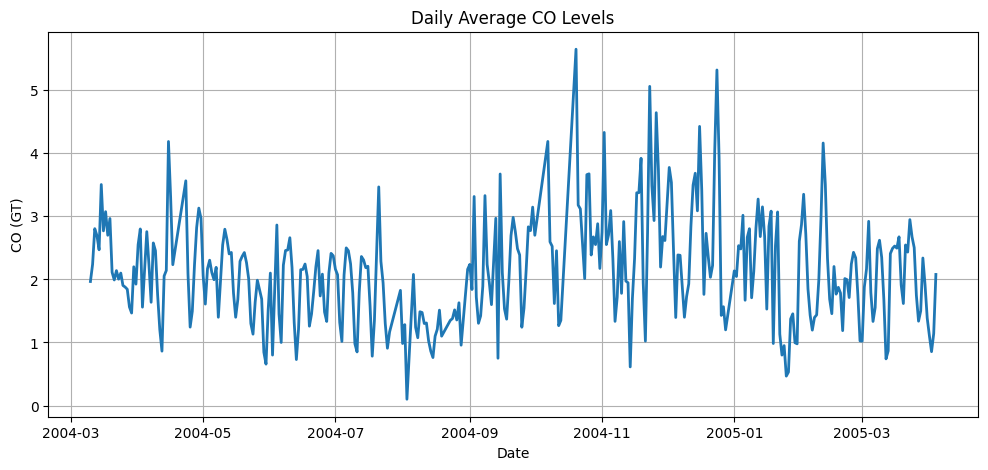

In [47]:
plt.figure(figsize=(12, 5))
plt.plot(daily_co.index, daily_co, linewidth=2)

plt.title("Daily Average CO Levels")
plt.xlabel("Date")
plt.ylabel("CO (GT)")
plt.grid(True)
plt.show()


### Interpretation: Daily Average CO Levels

The daily average Carbon Monoxide (CO) concentrations exhibit clear temporal variability, characterized by recurring peaks and troughs throughout the observation period. This indicates that CO levels fluctuate meaningfully from day to day, reflecting changes in emission intensity and environmental conditions.

Despite these fluctuations, there is no strong evidence of a sustained long-term upward or downward trend in daily CO concentrations across the study window. Instead, CO levels oscillate within a relatively stable range, suggesting that while short-term pollution episodes occur, the overall daily air-quality conditions remain broadly consistent over time.

Periods of elevated daily CO levels may be associated with factors such as increased traffic activity, meteorological influences (e.g., reduced dispersion), or seasonal patterns. The combination of daily aggregation and time-based interpolation effectively reduces high-frequency noise present in hourly measurements, allowing broader temporal patterns to emerge more clearly.

Overall, this visualization indicates that daily CO levels are dynamic yet structurally stable, making the series well-suited for further analysis, including rolling statistics, seasonal decomposition, and lag-based time-series forecasting models.


## Lag-Based Feature Engineering

Lag-based feature engineering introduces explicit temporal dependency into the dataset, allowing the modeling framework to leverage past Carbon Monoxide (CO) values when predicting current levels.

In this step:
- Lag features corresponding to the previous 1, 2, and 3 days are created
- These short-term lags are well-suited for capturing persistence effects commonly observed in air-quality time series
- Each lagged value represents historical information available at the time of prediction

By shifting the series backward in time, the model is prevented from accessing future information, thereby avoiding data leakage. The resulting lagged dataset forms the foundation for supervised time-series forecasting models.


In [48]:
# Create lag features
df_lag = pd.DataFrame({
    "CO": daily_co,
    "lag_1": daily_co.shift(1),
    "lag_2": daily_co.shift(2),
    "lag_3": daily_co.shift(3)
})

df_lag.head()


,CO,lag_1,lag_2,lag_3
datetime,,,,
2004-03-10,1.966667,NaN,NaN,NaN
2004-03-11,2.239130,1.966667,NaN,NaN
2004-03-12,2.804545,2.239130,1.966667,NaN
2004-03-13,2.695652,2.804545,2.239130,1.966667
2004-03-14,2.469565,2.695652,2.804545,2.239130


##  Cleaning Lagged Dataset

The lagged dataset contains missing values in the first few rows because past observations are not available at the beginning of the time series.

In this step:
- Rows with missing lag values are removed.
- Only observations with complete lag information are retained.

This prepares the dataset for reliable time-series modeling and analysis.


In [49]:
df_lag = df_lag.dropna()
df_lag.head()


,CO,lag_1,lag_2,lag_3
datetime,,,,
2004-03-13,2.695652,2.804545,2.239130,1.966667
2004-03-14,2.469565,2.695652,2.804545,2.239130
2004-03-15,3.504348,2.469565,2.695652,2.804545
2004-03-16,2.769565,3.504348,2.469565,2.695652
2004-03-17,3.073913,2.769565,3.504348,2.469565


## Train–Test Split for Time-Series Modeling

To evaluate model performance realistically, the lagged dataset is split into training and testing sets while preserving time order.

Steps performed:
- Use the first 80% of the data as the training set.
- Use the remaining 20% as the test set.
- Separate lag features (`lag_1`, `lag_2`, `lag_3`) as inputs.
- Use the current CO value as the target variable.

This approach prevents data leakage and reflects real-world forecasting scenarios where future values are predicted using past observations.


In [50]:
# Train-test split (80% train, 20% test)
split_index = int(len(df_lag) * 0.8)

train = df_lag.iloc[:split_index]
test = df_lag.iloc[split_index:]

X_train = train[["lag_1", "lag_2", "lag_3"]]
y_train = train["CO"]

X_test = test[["lag_1", "lag_2", "lag_3"]]
y_test = test["CO"]


In [51]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


## Linear Regression Model for CO Forecasting

To model and predict daily Carbon Monoxide (CO) levels, we train a Linear Regression model using lag features.

Steps performed:
- Initialize a Linear Regression model.
- Train the model using past CO values (`lag_1`, `lag_2`, `lag_3`) as input features.
- Generate predictions for the test dataset.

This model serves as a baseline forecasting approach and helps evaluate how well past CO concentrations explain current levels.


##  Model Evaluation Metrics

To evaluate the performance of the Linear Regression model, we compute two common error metrics:

- **Mean Absolute Error (MAE):** Measures the average absolute difference between actual and predicted CO values.
- **Root Mean Squared Error (RMSE):** Penalizes larger errors more strongly and highlights the presence of outliers.

Both metrics are expressed in the same units as the CO measurements, making them easy to interpret. Lower values indicate better model performance.


In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 0.508412902683015
RMSE: 0.618618688163047


## Interpretation of Results 

MAE=0.51

On average, the model’s predictions deviate from the true daily CO values by approximately 0.5 CO units.

RMSE=0.62

The slightly higher RMSE compared to MAE indicates the presence of larger prediction errors, consistent with the previously observed outliers and right-skewed distribution of CO values.

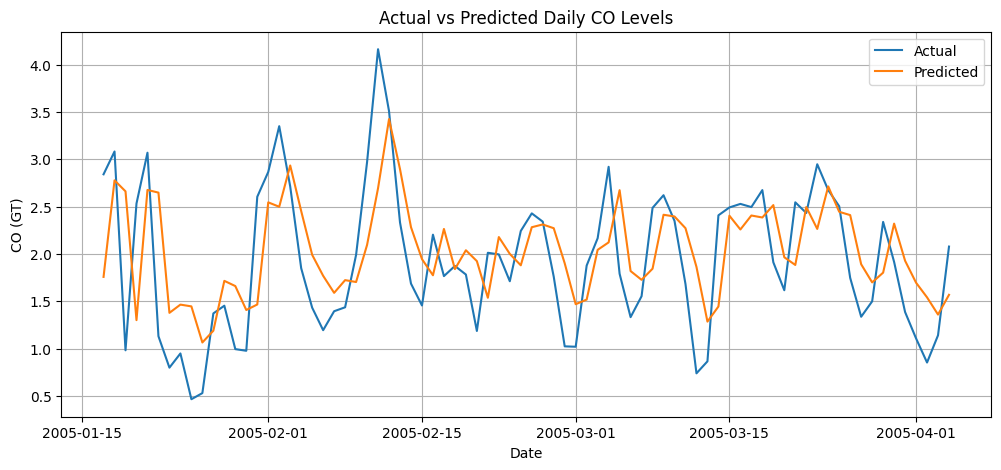

In [53]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")

plt.title("Actual vs Predicted Daily CO Levels")
plt.xlabel("Date")
plt.ylabel("CO (GT)")
plt.legend()
plt.grid(True)
plt.show()


## Actual vs Predicted Daily CO Levels

This plot compares the actual daily average Carbon Monoxide (CO) concentrations with the values predicted by the Linear Regression model over the test period.

The predicted CO values generally track the overall trend of the actual observations, indicating that the lag-based features (lag_1, lag_2, lag_3) successfully capture a portion of the temporal dependence in CO concentrations. This confirms that past CO levels provide meaningful information for forecasting near-future values.

However, the predicted series appears smoother than the actual data and consistently underestimates sharp peaks and sudden drops. During periods of rapid change or extreme CO values, the model fails to fully capture the magnitude of these fluctuations. This behavior is expected for a Linear Regression model, which assumes linear relationships and minimizes average error rather than prioritizing extreme events.

Overall, the visualization confirms that the Linear Regression model performs reasonably well as a baseline, capturing general patterns and medium-term variability in daily CO levels. Nevertheless, its inability to accurately model extreme pollution episodes highlights the limitations of linear approaches for this dataset and motivates the use of more flexible, non-linear models for improved forecasting performance.


##  Enhanced Feature Engineering for CO Forecasting

To improve model performance, additional time-series features are created by combining lag values with rolling statistics.

The feature set includes:
- Lag features (`lag_1`, `lag_2`, `lag_3`) to capture short-term temporal dependency.
- A 7-day rolling mean to represent weekly trends.
- A 7-day rolling standard deviation to measure recent variability in CO levels.
- A 14-day rolling mean to capture medium-term trends.

After feature construction, rows containing missing values introduced by lagging and rolling operations are removed to ensure a clean and temporally consistent dataset for modeling.

These engineered features provide richer temporal context, enabling non-linear models to better capture patterns, volatility, and extreme events in CO concentrations.


In [54]:
df_features = pd.DataFrame({
    "CO": daily_co,
    "lag_1": daily_co.shift(1),
    "lag_2": daily_co.shift(2),
    "lag_3": daily_co.shift(3),
    "rolling_mean_7": daily_co.rolling(7).mean(),
    "rolling_std_7": daily_co.rolling(7).std(),
    "rolling_mean_14": daily_co.rolling(14).mean()
})

df_features = df_features.dropna()
df_features.head()


,CO,lag_1,lag_2,lag_3,rolling_mean_7,rolling_std_7,rolling_mean_14
datetime,,,,,,,
2004-03-23,2.004348,2.139130,1.991304,2.113043,2.426708,0.471276,2.531174
2004-03-24,2.100000,2.004348,2.139130,1.991304,2.287578,0.384051,2.540697
2004-03-25,1.904167,2.100000,2.004348,2.139130,2.173887,0.358562,2.516771
2004-03-26,1.879167,1.904167,2.100000,2.004348,2.018737,0.102922,2.450673
2004-03-27,1.843478,1.879167,1.904167,2.100000,1.980228,0.111803,2.389803


## Train–Test Split with Enhanced Features

The enhanced feature dataset is divided into training and testing sets while preserving the temporal structure of the time series.

The following steps are performed:
- The first 80% of observations are used for model training
- The remaining 20% are reserved for model evaluation
- The target variable (CO) is separated from the input features, which include lag values and rolling statistical features
  
This time-aware splitting strategy ensures a fair and realistic evaluation of the forecasting model while leveraging the enriched temporal information provided by the enhanced feature set


In [55]:
split_index = int(len(df_features) * 0.8)

train = df_features.iloc[:split_index]
test = df_features.iloc[split_index:]

X_train = train.drop("CO", axis=1)
y_train = train["CO"]

X_test = test.drop("CO", axis=1)
y_test = test["CO"]


## Random Forest Model for CO Forecasting

To capture non-linear relationships and complex interactions in daily Carbon Monoxide (CO) levels, a Random Forest Regressor is trained using the enhanced time-series feature set.

The following steps are performed:
- A Random Forest model is initialized with 300 trees and a controlled maximum depth to balance model complexity and overfitting
- The model is trained using lag-based features and rolling statistical summaries
- Predictions are generated for the test dataset

Random Forest models are particularly well-suited for time-series feature representations, as they can naturally handle non-linearity, interactions among predictors, and robustness to correlated features—limitations observed in the linear baseline model


In [56]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    random_state=42
)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)


In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_rf = mean_absolute_error(y_test, rf_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_pred))

print("Random Forest MAE:", mae_rf)
print("Random Forest RMSE:", rmse_rf)


Random Forest MAE: 0.4779504332074483
Random Forest RMSE: 0.6303813039758853


## Random Forest Model Evaluation

The Random Forest model is evaluated using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) to assess its predictive accuracy on the test dataset.

- Random Forest MAE = 0.48
- Random Forest RMSE = 0.63
  
When compared to the Linear Regression baseline (MAE ≈ 0.51, RMSE ≈ 0.62), the Random Forest model achieves a lower MAE, indicating improved average predictive accuracy. This suggests that the enhanced feature set and the model’s ability to capture non-linear relationships help reduce typical prediction errors.

However, the RMSE is slightly higher than that of the Linear Regression model. This indicates that while the Random Forest improves overall average performance, it still produces some larger errors during extreme CO events, which are heavily penalized by RMSE. This behavior is consistent with the presence of occasional high-magnitude pollution episodes observed in the exploratory analysis.

Overall, the Random Forest model provides a stronger and more flexible forecasting approach than the linear baseline, particularly for capturing non-linear trends and medium-term variability. The results highlight a trade-off between improved average accuracy and sensitivity to extreme values, underscoring the challenges of modeling volatile environmental time series.

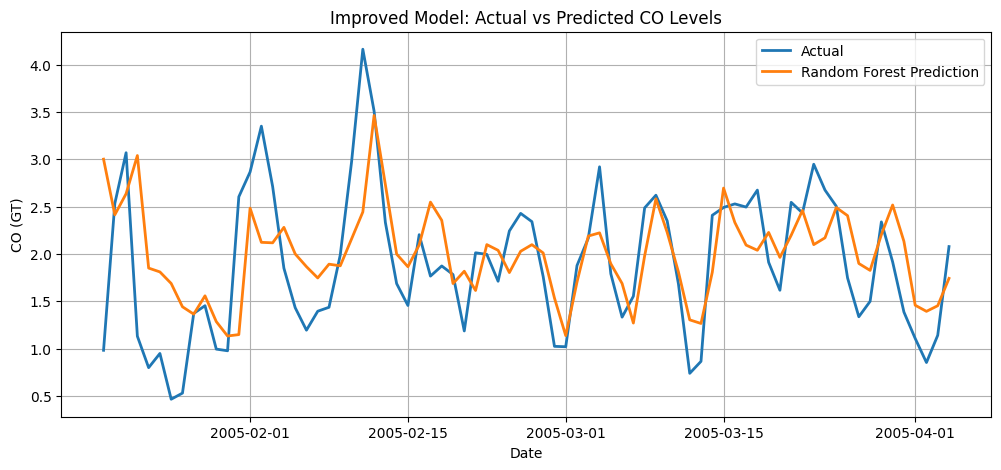

In [58]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, rf_pred, label="Random Forest Prediction", linewidth=2)

plt.title("Improved Model: Actual vs Predicted CO Levels")
plt.xlabel("Date")
plt.ylabel("CO (GT)")
plt.legend()
plt.grid(True)
plt.show()


## Interpretation: Random Forest Actual vs Predicted CO Levels


This plot compares the actual daily Carbon Monoxide (CO) concentrations with the values predicted by the Random Forest model over the test period.

The Random Forest predictions closely follow the overall temporal structure of the observed CO series, capturing both medium-term trends and many short-term fluctuations more effectively than the linear regression baseline. In particular, the predicted values align more closely with observed rises and declines in CO levels, indicating improved sensitivity to changes in air quality dynamics.

Compared to the linear regression model, the Random Forest demonstrates a better fit during periods of moderate variability, reducing average prediction error as reflected by the lower MAE. This improvement highlights the benefit of incorporating rolling statistical features and using a non-linear modeling approach capable of learning complex interactions among lagged and aggregated variables.

However, the predicted series remains slightly smoother than the actual observations, and some extreme peaks are still partially underestimated. This behavior is consistent with the slightly higher RMSE observed for the Random Forest model, suggesting that while overall accuracy improves, rare high-magnitude pollution events remain challenging to predict precisely.

Overall, this visualization confirms that the Random Forest model provides a more accurate and reliable representation of daily CO dynamics than the linear baseline, particularly for capturing non-linear patterns and temporal variability. The results support the conclusion that enhanced feature engineering combined with ensemble learning significantly improves short-term CO forecasting performance.


## Feature Importance

The feature importance results indicate that recent Carbon Monoxide (CO) values play the most significant role in predicting current CO levels. In particular, the 1-day lag (`lag_1`) is the most influential feature, highlighting strong short-term temporal dependence in the data.

Rolling mean features over 7 and 14 days also show high importance, suggesting that recent trends strongly affect daily CO concentrations. The rolling standard deviation contributes additional information by capturing short-term variability. Older lag features (`lag_2` and `lag_3`) have lower importance, indicating diminishing influence as time increases.

Overall, the feature importance analysis confirms that both recent values and short-term trends are key drivers of daily CO level predictions.


In [59]:


feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

feature_importance


lag_1              0.378299
rolling_mean_7     0.211403
rolling_std_7      0.136509
rolling_mean_14    0.100835
lag_2              0.091338
lag_3              0.081616
dtype: float64

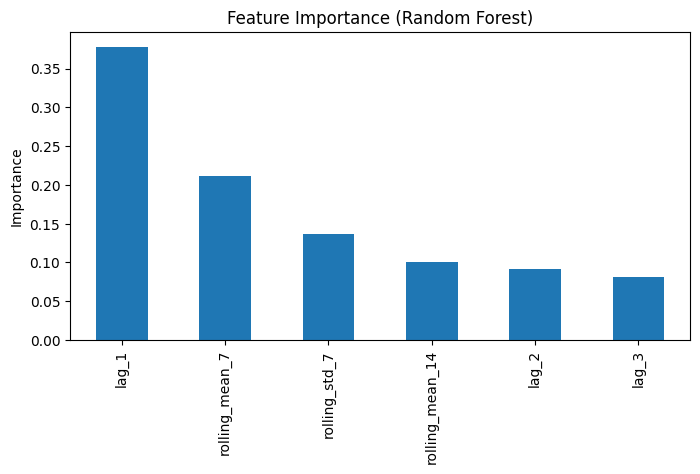

In [60]:
plt.figure(figsize=(8,4))
feature_importance.plot(kind="bar")
plt.title("Feature Importance (Random Forest)")
plt.ylabel("Importance")
plt.show()


## Interpretation: Feature Importance (Random Forest)

The feature importance plot illustrates the relative contribution of each engineered feature to the Random Forest model’s predictions of daily Carbon Monoxide (CO) levels.

The 1-day lag (lag_1) is the most influential feature by a substantial margin, indicating strong short-term temporal dependence in CO concentrations. This confirms that the most recent CO value is the single strongest predictor of current levels, a common characteristic of air-quality time series.

Rolling statistical features also play a significant role. The 7-day rolling mean ranks as the second most important feature, highlighting the influence of recent weekly trends on daily CO concentrations. The 7-day rolling standard deviation contributes additional predictive power by capturing short-term variability, suggesting that periods of increased volatility contain useful forecasting information.

The 14-day rolling mean shows moderate importance, reflecting the contribution of medium-term trends, while older lag features (lag_2 and lag_3) have lower importance. This pattern indicates a diminishing influence of past observations as temporal distance increases, with recent history being far more informative than older values.

Overall, the feature importance analysis confirms that the Random Forest model relies primarily on recent CO levels and short-term trends, validating the enhanced feature engineering strategy and explaining the model’s improved average forecasting accuracy compared to the linear baseline.


## Final Conclusion
In this project, daily Carbon Monoxide (CO) concentrations were analyzed and forecasted using a structured time-series modeling framework. The air-quality dataset was systematically cleaned, resampled to a daily frequency, and enhanced through feature engineering techniques, including lag variables and rolling statistical measures, to capture temporal dependency, trends, and variability.

A Linear Regression model was first implemented as a baseline forecasting approach. While this model demonstrated that historical CO values contain meaningful predictive information, it struggled to accurately represent sharp fluctuations and extreme pollution events due to its linear assumptions.

To address these limitations, an enhanced Random Forest model was trained using lag-based and rolling statistical features. The Random Forest achieved improved average predictive accuracy, as reflected by lower MAE values, and produced predictions that more closely aligned with observed CO dynamics. Visual comparisons further showed that the non-linear model was better able to track changes in CO levels over time, although extreme peaks remained challenging to predict precisely.

Feature importance analysis revealed that recent CO values, particularly the 1-day lag, are the most influential predictors, highlighting strong short-term temporal dependence in urban air-quality data. Rolling mean and variability features also played a significant role, confirming that short-term trends and recent volatility are key drivers of daily CO concentrations.

Overall, this study demonstrates that combining time-series feature engineering with non-linear ensemble models provides an effective and robust approach for forecasting urban air pollution levels. Future work could extend this analysis by incorporating additional meteorological variables, exploring longer forecasting horizons, or applying advanced time-series methods such as gradient boosting models or recurrent neural networks to further improve predictive performance.